## Document Classification using NLP, Machine Learning


In [3]:
import pandas, numpy, string, textblob
import pickle
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, decomposition, ensemble
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import xgboost
from keras import layers, models, optimizers
from keras.preprocessing import text, sequence
import matplotlib.pyplot as plt

### Dataset
n four categories- World, Sports, Business, Sci/Tech. It also includes 7600 testing samples in csv format. I have used pandas library to load the dataset.

In [4]:
#Load training data
df_train = pandas.read_csv('dataset/ag_news/train.csv')
# df_train = df_train.truncate(after=10000)
#Load testing data
df_test = pandas.read_csv('dataset/ag_news/test.csv')

In [5]:
df_train.head()
df_train.info()
df_count = df_train.groupby(['Class Index'], as_index = False).agg({'Title': 'count', 'Description': 'count'})
df_count.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


,Class Index,Title,Description
0,1,30000,30000
1,2,30000,30000
2,3,30000,30000
3,4,30000,30000


### Text Pre-processing


In [6]:
import re, unidecode
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize


import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text
def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text
def remove_numbers(text): 
    result = re.sub(r'\d+', '', text) 
    return result
def remove_slash_with_space(text): 
    return text.replace('\\', " ")
def remove_punctuation(text): 
    translator = str.maketrans('', '', string.punctuation) 
    return text.translate(translator) 
def text_lowercase(text): 
    return text.lower()     
def remove_whitespace(text): 
    return  " ".join(text.split()) 
def remove_stopwords(text): 
    stop_words = set(stopwords.words("english")) 
    word_tokens = word_tokenize(text) 
    filtered_text = [word for word in word_tokens if word not in stop_words] 
    return ' '.join(filtered_text)
def stem_words(text): 
    stemmer = PorterStemmer() 
    word_tokens = word_tokenize(text) 
    stems = [stemmer.stem(word) for word in word_tokens] 
    return ' '.join(stems)
def lemmatize_words(text): 
    lemmatizer = WordNetLemmatizer() 
    word_tokens = word_tokenize(text) 
    # provide context i.e. part-of-speech 
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens] 
    return ' '.join(lemmas) 


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SHALIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SHALIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SHALIN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# Perform preprocessing
def perform_preprocessing(text):
    text = remove_html_tags(text)
    text = remove_accented_chars(text)
    text = remove_numbers(text)
    text = remove_stopwords(text)
    text = text_lowercase(text)
    text = remove_slash_with_space(text)
    text = remove_punctuation(text)
    # text = stem_words(text)
    text = lemmatize_words(text)
    text = remove_whitespace(text)
    return text

df_train['Title'] = df_train['Title'].apply(perform_preprocessing)
df_train['Description'] = df_train['Description'].apply(perform_preprocessing)
df_test['Title'] = df_test['Title'].apply(perform_preprocessing)
df_test['Description'] = df_test['Description'].apply(perform_preprocessing)


C:\Users\SHALIN\AppData\Local\Temp\ipykernel_14188\3396724914.py:15: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


### Train test split

In [8]:
X_train = df_train['Description']
X_test = df_test['Description']
y_train = df_train['Class Index']
y_test = df_test['Class Index']

### Feature Engineering


In [9]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(X_train)
X_train_count =  count_vect.transform(X_train)
X_test_count =  count_vect.transform(X_test)

In [10]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(X_train)
X_train_tfidf =  tfidf_vect.transform(X_train)
X_test_tfidf =  tfidf_vect.transform(X_test)

3. TF-IDF Vectors N-Gram level – In this approach for better results, have combined N (>= 2) words to form N-grams. Bigrams (N=2) are the most optimal and best convey most important information among other N-grams. 

In [11]:
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,2), max_features=5000)
tfidf_vect_ngram.fit(X_train)
X_train_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
X_test_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)

4. TF-IDF Vectors Character level- character level

In [12]:
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(X_train)
X_train_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_train) 
X_test_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_test) 

c:\Users\SHALIN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:554: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn(


5. Text / NLP based features - I tried adding additional NLP features namely word count, character count, average word density, title word count but I found them harmful to model accuracy. So, I have removed them. 

In [13]:
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

encoder = preprocessing.LabelBinarizer()
encoder.fit(y_train)
y_train_bi = encoder.transform(y_train)
y_test_bi = encoder.transform(y_test)

###	MODEL SELECTION AND TRAINING
#### Classical models (Used as a Baseline Model)

In [15]:
def train_model(classifier, X_train, y_train, X_test, y_test, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(X_train, y_train)
    # predict the labels on validation dataset
    predictions = classifier.predict(X_test)
    return metrics.accuracy_score(predictions, y_test)

NB, Count Vectors:  0.8956578947368421
NB, WordLevel TF-IDF:  0.8836842105263157
NB, N-Gram Vectors:  0.8797368421052632
NB, CharLevel Vectors:  0.8444736842105263


<BarContainer object of 4 artists>

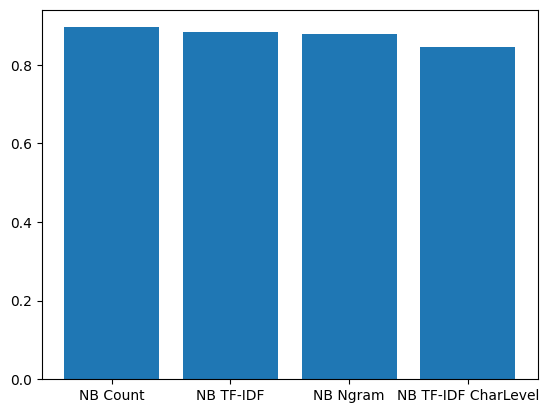

In [16]:
# Naive Bayes on Count Vectors
accuracy1 = train_model(naive_bayes.MultinomialNB(), X_train_count, y_train, X_test_count, y_test)
print("NB, Count Vectors: ", accuracy1)

# Naive Bayes on Word Level TF IDF Vectors
accuracy2 = train_model(naive_bayes.MultinomialNB(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("NB, WordLevel TF-IDF: ", accuracy2)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy3 = train_model(naive_bayes.MultinomialNB(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram, y_test)
print("NB, N-Gram Vectors: ", accuracy3)

# Naive Bayes on Character Level TF IDF Vectors
accuracy4 = train_model(naive_bayes.MultinomialNB(), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars, y_test)
print("NB, CharLevel Vectors: ", accuracy4)

df = {'ModelType': ['NB Count', 'NB TF-IDF','NB Ngram', 'NB TF-IDF CharLevel' ], 'Accuracy': [accuracy1,accuracy2, accuracy3,accuracy4]}
df = pandas.DataFrame(df) #
plt.bar(df['ModelType'], df['Accuracy'])

c:\Users\SHALIN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR, Count Vectors:  0.8990789473684211


c:\Users\SHALIN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR, WordLevel TF-IDF:  0.8986842105263158


c:\Users\SHALIN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR, N-Gram Vectors:  0.8969736842105264
LR, CharLevel Vectors:  0.881578947368421


c:\Users\SHALIN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<BarContainer object of 4 artists>

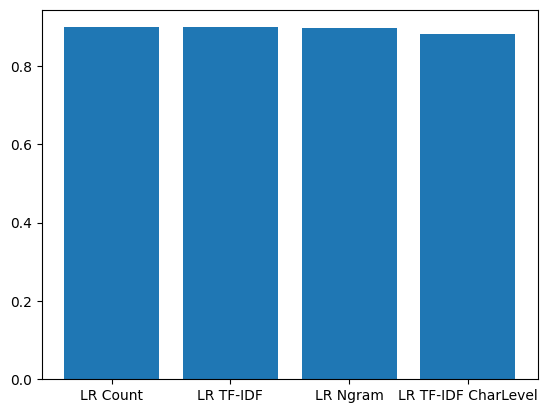

In [17]:
# Logistic Regression on Count Vectors
accuracy1 = train_model(linear_model.LogisticRegression(), X_train_count, y_train, X_test_count, y_test)
print("LR, Count Vectors: ", accuracy1)

# Logistic Regression on Word Level TF IDF Vectors
accuracy2 = train_model(linear_model.LogisticRegression(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("LR, WordLevel TF-IDF: ", accuracy2)

# Logistic Regression on Ngram Level TF IDF Vectors
accuracy3 = train_model(linear_model.LogisticRegression(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram, y_test)
print("LR, N-Gram Vectors: ", accuracy3)

# Logistic Regression on Character Level TF IDF Vectors
accuracy4 = train_model(linear_model.LogisticRegression(), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars, y_test)
print("LR, CharLevel Vectors: ", accuracy4)

df = {'ModelType': ['LR Count', 'LR TF-IDF','LR Ngram', 'LR TF-IDF CharLevel' ], 'Accuracy': [accuracy1,accuracy2, accuracy3,accuracy4]}
df = pandas.DataFrame(df) #
plt.bar(df['ModelType'], df['Accuracy'])

Bagging Model (Random Forest) - Random Forest models are a type of ensemble models, particularly bagging models. The main aim of these models is to reduce the overfitting. They work towards reducing the model complexity. 

In [18]:
# RF on Count Vectors
accuracy1 = train_model(ensemble.RandomForestClassifier(), X_train_count, y_train, X_test_count, y_test)
print("RF, Count Vectors: ", accuracy1)

# RF on Word Level TF IDF Vectors
accuracy2 = train_model(ensemble.RandomForestClassifier(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("RF, WordLevel TF-IDF: ", accuracy2)

XG Boost - Boosting models are type of ensemble models and work to improve the model prediction rates. This model is meta-algorithm for reducing bias and variance in supervised learning. One of its strong points is that it converts weak learner i.e. classifiers slightly correlated to the true classification into stronger ones. 

In [ ]:
# Extereme Gradient Boosting (XG boost) on Count Vectors
accuracy3 = train_model(xgboost.XGBClassifier(), X_train_count.tocsc(), y_train, X_test_count.tocsc(), y_test)
print("Xgb, Count Vectors: ", accuracy3)

# Extereme Gradient Boosting on Word Level TF IDF Vectors
accurac4 = train_model(xgboost.XGBClassifier(), X_train_tfidf.tocsc(), y_train, X_test_tfidf.tocsc(), y_test)
print("Xgb, WordLevel TF-IDF: ", accuracy4)

# # Extereme Gradient Boosting on Character Level TF IDF Vectors
# accuracy = train_model(xgboost.XGBClassifier(), X_train_tfidf_ngram_chars.tocsc(), y_train, X_test_tfidf_ngram_chars.tocsc(), y_test)
# print("Xgb, CharLevel Vectors: ", accuracy)
df = {'ModelType': ['RF count', 'RF TF-IDF','XG Count', 'XG TF-IDF' ], 'Accuracy': [accuracy1,accuracy2, accuracy3,accuracy4]}
df = pandas.DataFrame(df) #
plt.bar(df['ModelType'], df['Accuracy'])

In [ ]:
plt.style.use('ggplot')
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [16]:
vocab_size = 15000
num_labels = 4
batch_size = 100
maxlen = 200

tokenizer = text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding again 1 because of reserved 0 index

X_train_token = sequence.pad_sequences(X_train_token, padding='post', maxlen=maxlen)
X_test_token = sequence.pad_sequences(X_test_token, padding='post', maxlen=maxlen)
embedding_dim = 300

### More Feature Engineering


In [24]:
# create embedding matrix using pre-trained word vectors
def create_embedding_matrix(filepath, word_index, embedding_dim):
    embedding_matrix = numpy.zeros((vocab_size, embedding_dim))

    with open(filepath,'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = numpy.array(
                    vector, dtype=numpy.float32)[:embedding_dim]

    return embedding_matrix

#basic new word embed
embedding_matrix = create_embedding_matrix('word_embeddings/glove.6B.300d.txt',tokenizer.word_index, embedding_dim)
nonzero_elements = numpy.count_nonzero(numpy.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements / vocab_size)


0.7124104223770681


In [25]:
# Shallow neural network basic with word embedding matrix
embedding_dim = 300

model = models.Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim,
                           weights=[embedding_matrix],
                           input_length=maxlen,
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(512, input_shape=(vocab_size,)))
model.add(layers.Activation('relu'))
model.add(layers.Dense(4))
model.add(layers.Activation('softmax'))
# model.summary()
 
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
history = model.fit(X_train_token, y_train_bi,
                    batch_size=batch_size,
                    epochs=10,
                    validation_split=0.1,
                    verbose=1)

loss, accuracy = model.evaluate(X_train_token, y_train_bi, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_token, y_test_bi, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


C:\Users\Saurabh\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 108000 samples, validate on 12000 samples
Epoch 1/10
108000/108000 [==============================] - 14s 134us/step - loss: 0.3789 - accuracy: 0.8720 - val_loss: 0.2854 - val_accuracy: 0.8988 - ETA: 20s - loss: 1.0372 - accuracy: 0.6076

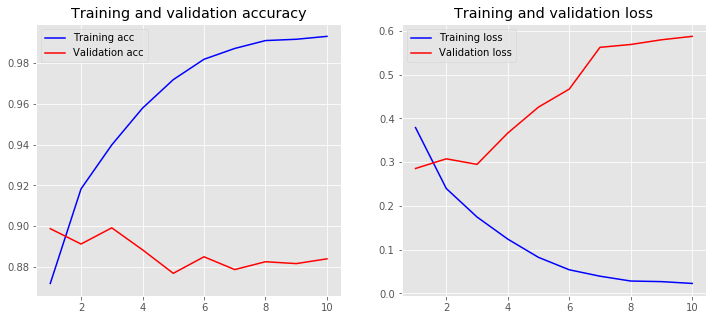

In [26]:
plot_history(history)

In [27]:
# Deep Neural networks CNN
model = models.Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim,
                           weights=[embedding_matrix],
                           input_length=maxlen,
                           trainable=True))
model.add(layers.SpatialDropout1D(0.3))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(256))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(4))
model.add(layers.Activation('softmax'))
# model.summary()
 
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
history = model.fit(X_train_token, y_train_bi,
                    batch_size=30,
                    epochs=10,
                    validation_split=0.1,
                    verbose=1)

loss, accuracy = model.evaluate(X_train_token, y_train_bi, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_token, y_test_bi, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

C:\Users\Saurabh\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 108000 samples, validate on 12000 samples
Epoch 1/10
108000/108000 [==============================] - 54s 501us/step - loss: 0.3317 - accuracy: 0.8885 - val_loss: 0.2489 - val_accuracy: 0.9118

### Saving Model
#### Save the model as well as tokenizer.

We have to save our tokenizer because it is our vocabulary. The same tokenizer and vocabulary have to be used for accurate prediction.

In [32]:
# creates a HDF5 file 'my_model.h5'
model.model.save('save/my_model.h5')

# Save Tokenizer i.e. Vocabulary
with open('save/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Bi directional rnn gru

model = models.Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim,
                           weights=[embedding_matrix],
                           input_length=maxlen,
                           trainable=True))
model.add(layers.SpatialDropout1D(0.3))
model.add(layers.Bidirectional(layers.GRU(100)))
model.add(layers.Dense(512, input_shape=(vocab_size,)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(4))
model.add(layers.Activation('softmax'))
# model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train_token, y_train_bi,
                    batch_size=batch_size,
                    epochs=5,
                    validation_split=0.1,
                    verbose=1)

loss, accuracy = model.evaluate(X_train_token, y_train_bi, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_token, y_test_bi, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

### Hyper Parameter Tuning
To improve the model, I further resorted to trying different feature vectors and other combination of hyperparameter tuning. Tuning the paramters is an important step as I found that what works for one problem may not be best for another. I used Randomized Grid search for tuning. It takes lists of parameters and it runs the model with each parameter combination. Then I used the Keras classifier to create keras models. Doing so we get access to cross-validation technique of scikit-learn library. I used k-fold cross-validation. I have used k in the range of 10 to 15. This essentially divides my dataset into k sets of which k-1 sets are used for training the model and the remaining one set is used for model testing. This enabled me to run k different runs, where each partition is once used as a testing set. The end result is I got the parameter values which provided the best performances which I used in my final model.

In [42]:
# #basic new 3 cnn tuned
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = models.Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(512))
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(4))
    model.add(layers.Activation('softmax'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
epochs = 20
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[vocab_size], 
                  embedding_dim=[embedding_dim],
                  maxlen=[maxlen])
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
grid_result = grid.fit(X_train_token, y_train_bi)

test_accuracy = grid.score(X_test_token, y_test_bi)
s = ('data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
output_string = s.format(
            grid_result.best_score_,
            grid_result.best_params_,
            test_accuracy)
print(output_string)


TypeError: 'dict' object is not callable

### Live Testing


#### Loading the best model

In [98]:
final_model = models.load_model('my_model.h5')
 
# load tokenizer
tokenizer = text.Tokenizer()
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)


In [78]:
class_dict = {'0': 'World', '1': 'Sports','2': 'Business','3': 'Sci/Tech'}
inp = ["In the ever-evolving world of business, adaptability and innovation are fundamental to success. Companies across the globe continually seek ways to streamline their operations and provide exceptional value to their customers. The digital age has ushered in an era of connectivity and data-driven decision-making, allowing businesses to reach new markets and expand their reach. Additionally, sustainability has become a significant focus, with environmentally responsible practices not only benefiting the planet but also appealing to a growing eco-conscious consumer base. Amidst the dynamic landscape of economic shifts and market competition, businesses that embrace change, foster innovation, and prioritize customer satisfaction are poised to thrive and shape the future of commerce."]
inp = [perform_preprocessing(x) for x in inp]
inp_token = tokenizer.texts_to_sequences(inp)
inp_token = sequence.pad_sequences(inp_token, padding='post', maxlen=maxlen)

out = final_model.predict(inp_token)
predicted_label = numpy.argmax(out) 
print("Predicted label: " + class_dict.get(str(predicted_label)))

1/1 [==============================] - 0s 239ms/step
Predicted label: Sci/Tech


In [100]:
from googletrans import Translator
import numpy as np
from keras.preprocessing import sequence
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
import os

# Define your class_dict
class_dict = {'0': 'World', '1': 'Sports', '2': 'Business', '3': 'Sci/Tech'}

# Prompt the user for input
user_input = input("Enter your mixed-language input: ")
inp = [user_input]

# Define a function for preprocessing (you should implement this function)
# def perform_preprocessing(text):
#     # Implement your text preprocessing logic here
#     return text

# Preprocess the user input
inp = [perform_preprocessing(x) for x in inp]

# Assuming you have your tokenizer and maxlen defined elsewhere in your code
# Tokenize and pad the preprocessed input
inp_token = tokenizer.texts_to_sequences(inp)
inp_token = sequence.pad_sequences(inp_token, padding='post', maxlen=maxlen)

# Create a translator instance
translator = Translator()

# Translate the mixed-language input to English
translated_inp = [translator.translate(sentence, src='auto', dest='en').text for sentence in inp]

# Tokenize and pad the translated input
inp_token = tokenizer.texts_to_sequences(translated_inp)
inp_token = sequence.pad_sequences(inp_token, padding='post', maxlen=maxlen)

# Now you can proceed to use your loaded model for prediction
out = final_model.predict(inp_token)  # Replace with your actual model prediction code
predicted_label = np.argmax(out)
predicted_class = class_dict.get(str(predicted_label))

# Create a folder based on the predicted class
output_folder = "output_folder"  # Replace with your desired folder path
class_folder = os.path.join(output_folder, predicted_class)
os.makedirs(class_folder, exist_ok=True)

# Generate a unique filename for the PDF and text files
file_number = len(os.listdir(class_folder)) + 1
pdf_filename = os.path.join(class_folder, f"input_{file_number}.pdf")
text_filename = os.path.join(class_folder, f"input_{file_number}.txt")

# Save the user input in a PDF file
c = canvas.Canvas(pdf_filename, pagesize=letter)
c.drawString(100, 700, "Predicted Class: " + predicted_class)
c.drawString(100, 650, "Input Text:")
c.drawString(100, 630, user_input)  # Add the user input to the PDF
c.save()

# Save the user input in a text file
with open(text_filename, 'w', encoding='utf-8') as text_file:
    text_file.write("Predicted Class: " + predicted_class + "\n")
    text_file.write("Input Text:\n")
    text_file.write(user_input)

# Print the predicted class to the console
print("Predicted Class:", predicted_class)

print("Saved input to PDF:", pdf_filename)
print("Saved input to text:", text_filename)


1/1 [==============================] - 0s 47ms/step
Predicted Class: Sci/Tech
Saved input to PDF: output_folder\Sci/Tech\input_29.pdf
Saved input to text: output_folder\Sci/Tech\input_29.txt


In [112]:
import tkinter as tk
from googletrans import Translator
import os
from keras.preprocessing import sequence
import numpy as np
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas

# Define your class_dict
class_dict = {'0': 'World', '1': 'Sports', '2': 'Business', '3': 'Sci/Tech'}

# Define a function for preprocessing (you should implement this function)
def perform_preprocessing(text):
    # Implement your text preprocessing logic here
    return text

# Function to handle the "Classify" button click
def classify_text():
    # Get user input from the text box
    user_input = input_text.get("1.0", "end-1c")

    # Preprocess the user input
    inp = [perform_preprocessing(user_input)]

    # Tokenize and pad the preprocessed input
    inp_token = tokenizer.texts_to_sequences(inp)
    inp_token = sequence.pad_sequences(inp_token, padding='post', maxlen=maxlen)

    # Create a translator instance
    translator = Translator()

    # Translate the mixed-language input to English
    translated_inp = [translator.translate(sentence, src='auto', dest='en').text for sentence in inp]

    # Tokenize and pad the translated input
    inp_token = tokenizer.texts_to_sequences(translated_inp)
    inp_token = sequence.pad_sequences(inp_token, padding='post', maxlen=maxlen)

    # Now you can proceed to use your loaded model for prediction
    out = final_model.predict(inp_token)  # Replace with your actual model prediction code
    predicted_label = np.argmax(out)
    predicted_class = class_dict.get(str(predicted_label))

    # Show the predicted class in the GUI
    predicted_class_label.config(text="Predicted Class: " + predicted_class)

    # Create a folder based on the predicted class
    output_folder = "output_folder"  # Replace with your desired folder path
    class_folder = os.path.join(output_folder, predicted_class)
    os.makedirs(class_folder, exist_ok=True)

    # Generate a unique filename for the PDF and text files
    file_number = len(os.listdir(class_folder)) + 1
    pdf_filename = os.path.join(class_folder, f"input_{file_number}.pdf")
    text_filename = os.path.join(class_folder, f"input_{file_number}.txt")

    # Save the user input in a PDF file
    c = canvas.Canvas(pdf_filename, pagesize=letter)
    c.drawString(100, 700, "Predicted Class: " + predicted_class)
    c.drawString(100, 650, "Input Text:")
    c.drawString(100, 630, user_input)  # Add the user input to the PDF
    c.save()

    # Save the user input in a text file
    with open(text_filename, 'w', encoding='utf-8') as text_file:
        text_file.write("Predicted Class: " + predicted_class + "\n")
        text_file.write("Input Text:\n")
        text_file.write(user_input)

# Create a GUI
root = tk.Tk()
root.title("Mixed Language Input Classification")

# Create a text box for user input
input_text = tk.Text(root, height=20, width=80)
input_text.pack()

# Create a "Classify" button
classify_button = tk.Button(root, text="Classify", command=classify_text)
classify_button.pack()

# Create a label to display the predicted class
predicted_class_label = tk.Label(root, text="")
predicted_class_label.pack()

# Start the GUI mainloop
root.mainloop()


1/1 [==============================] - 0s 46ms/step


In [ ]:
from googletrans import Translator
import numpy as np
from keras.preprocessing import sequence
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
import os

# Define your class_dict
class_dict = {'0': 'World', '1': 'Sports', '2': 'Business', '3': 'Sci/Tech'}

# Prompt the user for input
user_input = input("Enter your mixed-language input: ")
inp = [user_input]

# Define a function for preprocessing (you should implement this function)
# def perform_preprocessing(text):
#     # Implement your text preprocessing logic here
#     return text

# Preprocess the user input
inp = [perform_preprocessing(x) for x in inp]

# Assuming you have your tokenizer and maxlen defined elsewhere in your code
# Tokenize and pad the preprocessed input
inp_token = tokenizer.texts_to_sequences(inp)
inp_token = sequence.pad_sequences(inp_token, padding='post', maxlen=maxlen)

# Create a translator instance
translator = Translator()

# Translate the mixed-language input to English
translated_inp = [translator.translate(sentence, src='auto', dest='en').text for sentence in inp]

# Tokenize and pad the translated input
inp_token = tokenizer.texts_to_sequences(translated_inp)
inp_token = sequence.pad_sequences(inp_token, padding='post', maxlen=maxlen)

# Now you can proceed to use your loaded model for prediction
out = final_model.predict(inp_token)  # Replace with your actual model prediction code
predicted_label = np.argmax(out)
predicted_class = class_dict.get(str(predicted_label))

# Create a folder based on the predicted class
output_folder = "output_folder"  # Replace with your desired folder path
class_folder = os.path.join(output_folder, predicted_class)
os.makedirs(class_folder, exist_ok=True)

# Generate a unique filename for the PDF and text files
file_number = len(os.listdir(class_folder)) + 1
pdf_filename = os.path.join(class_folder, f"input_{file_number}.pdf")
text_filename = os.path.join(class_folder, f"input_{file_number}.txt")

# Save the user input in a PDF file
c = canvas.Canvas(pdf_filename, pagesize=letter)
c.drawString(100, 700, "Predicted Class: " + predicted_class)
c.drawString(100, 650, "Input Text:")
c.drawString(100, 630, user_input)  # Add the user input to the PDF
c.save()

# Save the user input in a text file
with open(text_filename, 'w', encoding='utf-8') as text_file:
    text_file.write("Predicted Class: " + predicted_class + "\n")
    text_file.write("Input Text:\n")
    text_file.write(user_input)

# Print the predicted class to the console
print("Predicted Class:", predicted_class)

print("Saved input to PDF:", pdf_filename)
print("Saved input to text:", text_filename)


TypeError: the JSON object must be str, bytes or bytearray, not NoneType